In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy
import corner
from IPython.display import display, Math
import pandas as pd

In [54]:
# define useful functions - for now Omg_k is zero

# Equation 2.14
def Omega_Lambda(cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    
    return 1 - Omega_m - Omega_r - Omega_k + alpha_tilde * (1 - C_t**2 + Omega_k**2 - 2*Omega_k)

# Equation 2.13
def X(z, cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    return 1 + 4 * alpha_tilde * (Omega_m * (1 + z) ** 3 + (Omega_r + alpha_tilde*C_t**2) * (1 + z)** 4 + Omega_lambda)

# Equation 2.12
def E(z , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    E_L = Omega_m * (1 + z) ** 3 + (Omega_r + alpha_tilde*C_t**2) * (1 + z) ** 4 + Omega_lambda
    
    if alpha_tilde == 0:
        ans = np.sqrt(E_L + Omega_k * (1 + z) ** 2)
    
    else:
        ans = np.sqrt((np.sqrt(X(z , cosmo)) - 1 + (2 * alpha_tilde * Omega_k * (1+z) ** 2))/(2 * alpha_tilde))
    
    return ans

# sound horizon
def r_s_fracH0c(z,cosmo, a_min):
    Omg_c , Omg_b , Omg_k , Omg_r, alpha_t, C_t = cosmo
    Omg_m = Omg_b + Omg_c 
    
    return scipy.integrate.quad(lambda x: 1/((x**2)*E(1/x -1, cosmo)*np.sqrt(3*(1 + R_b(Omg_b*h**2)*x))), a_min, 1/(1+z))[0]

# particle horizon
def r_hor_fracH0c(z,cosmo, a_min):
    Omg_c , Omg_b , Omg_k , Omg_r, alpha_t, C_t = cosmo
    Omg_m = Omg_b + Omg_c 
    
    return scipy.integrate.quad(lambda x: 1/((x**2)*E(1/x -1, cosmo)), a_min, 1/(1+z))[0]

# Used to find z_CMB
def g1(wb):
    return (0.0783*wb**(-0.238))/(1 + 39.5*wb**(0.763))

# Used to find z_CMB
def g2(wb):
    return 0.56/(1 + 21.1*wb**(1.81))

# redshift at which the BB occurs
def z_CMB(Omg_b,Omg_m,h):
    wb = Omg_b * h**2
    wm = Omg_m * h**2
    return 1048*(1+0.00124*wb**(-0.738))*\
           (1 + g1(wb)*wm**g2(wb))

# Used to find r_s
def R_b(wb):
    return 31500*wb*(2.7255/2.7)**(-4)

# Shift parameter
def R(cosmo,h):
    Omg_c , Omg_b , Omg_k , Omg_r, alpha_t, C_t = cosmo
    Omg_m = Omg_b + Omg_c 
    return np.sqrt(Omg_m)*scipy.integrate.quad(lambda x: 1/E(x,cosmo), 0 , z_CMB(Omg_b,Omg_m,h))[0]

# Acoustic scale
def l_A(cosmo,h):
    Omg_c , Omg_b , Omg_k , Omg_r, alpha_t, C_t = cosmo
    Omg_m = Omg_b + Omg_c 
    return np.pi*scipy.integrate.quad(lambda x: 1/E(x,cosmo), 0 , z_CMB(Omg_b,Omg_m,h))[0]/\
           (scipy.integrate.quad(lambda x: 1/((x**2)*E(1/x -1, cosmo)*np.sqrt(3*(1 + R_b(Omg_b*h**2)*x))), 1e-2, 1/(1+z_CMB(Omg_b,Omg_m,h)))[0])


In [55]:
# try some values
cosmotry = [0.0453,0.027,0,9.227e-5,1e-12,0]
cosmotry_LCDM = [0.0453,0.027,0,9.227e-5,0,0]
h = 0.67
z_CMB_val = z_CMB(cosmotry[1],(cosmotry[0]+cosmotry[1]),h)

R_data = 1.74963 #\pm 5e-3 (assume no cross correlation - false)
l_a_data = 301.80845 #\pm 0.09
a_min = 2.5e-9

print(r_s_fracH0c(z_CMB_val, cosmotry, a_min))
print(np.pi*R_data/(l_a_data*np.sqrt(cosmotry[0]+cosmotry[1])))

0.10196425634988468
0.06773225672715623


In [56]:
print(r_hor_fracH0c(z_CMB_val,cosmotry_LCDM, 0))
print(r_hor_fracH0c(z_CMB_val,cosmotry, 1e-28))

0.08212404448086973
0.47699994096553616


/tmp/ipykernel_994274/1220632732.py:48: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return scipy.integrate.quad(lambda x: 1/((x**2)*E(1/x -1, cosmo)), a_min, 1/(1+z))[0]


In [57]:
a_LCDM = np.linspace(1e-20,1e-1, int(1e3))
a = np.linspace(2e-9,1e-1, int(1e3))

r_horizon_LCDM = np.zeros(len(a))
r_horizon = np.zeros(len(a))

for i in range(len(a)):
    r_horizon[i] = r_hor_fracH0c(1/a[i] - 1 , cosmotry, 1e-9)
    r_horizon_LCDM[i] = r_hor_fracH0c(1/a_LCDM[i] - 1,cosmotry_LCDM, 0)


/tmp/ipykernel_994274/1220632732.py:48: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return scipy.integrate.quad(lambda x: 1/((x**2)*E(1/x -1, cosmo)), a_min, 1/(1+z))[0]
/tmp/ipykernel_994274/1220632732.py:48: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return scipy.integrate.quad(lambda x: 1/((x**2)*E(1/x -1, cosmo)), a_min, 1/(1+z))[0]


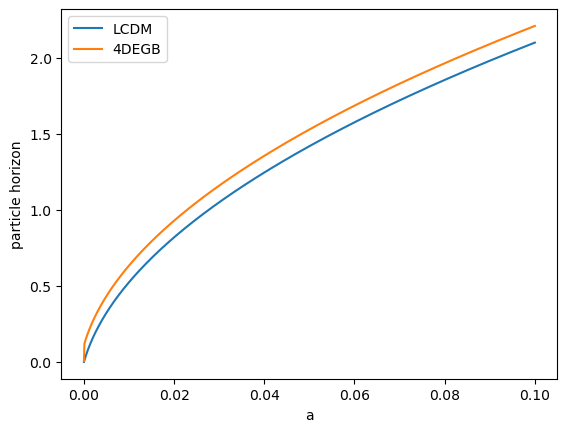

In [58]:
plt.plot(a_LCDM,r_horizon_LCDM, label = "LCDM")
plt.plot(a,r_horizon, label = "4DEGB")
#plt.plot(np.ones(int(1e2)), np.linspace(np.min(r_horizon),np.max(r_horizon), int(1e2)), "k--", label = "today")

plt.xlabel("a")
plt.ylabel("particle horizon")
plt.legend()

/tmp/ipykernel_994274/578602232.py:5: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(a, 1/(a*E(1/a -1 , cosmotry)))


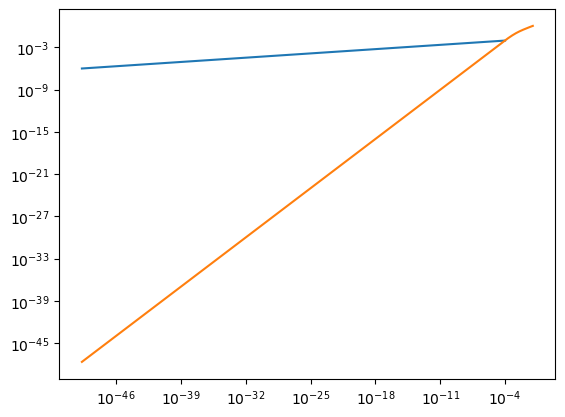

In [64]:
cosmotry = [0.0453,0.027,0,9.227e-5,1e-28,0]
cosmotry_LCDM = [0.0453,0.027,0,9.227e-5,0,0]

a = np.linspace(2e-50,1e-1, int(1e3))
plt.plot(a, 1/(a*E(1/a -1 , cosmotry)))

plt.plot(a, 1/(a*E(1/a -1 , cosmotry_LCDM)))
plt.xscale("log")
plt.yscale("log")